In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.svm import OneClassSVM

def load_images_from_folder(folder, target_size=(128, 128)):
    """
    Loads all .jpg, .jpeg, or .png images from a folder,
    resizes them to target_size, and returns a numpy array along with filenames.
    """
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder, filename)
            try:
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                images.append(img_array)
                filenames.append(filename)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return np.array(images), filenames


In [ ]:
def build_autoencoder(input_shape=(128, 128, 3)):
    input_img = tf.keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
    # Save the encoded output with a name so we can extract it later
    encoded = layers.MaxPooling2D((2,2), padding='same', name='encoded_layer')(x)

    # Decoder
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Create an encoder model to extract the latent representation.
    encoder = models.Model(inputs=input_img, outputs=autoencoder.get_layer('encoded_layer').output)

    return autoencoder, encoder

# Build the models.
autoencoder, encoder = build_autoencoder()
autoencoder.summary()  # Optional: prints the model architecture


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded_layer (MaxPooling2D)         │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Update with the path to your shoreline images directory.
image_dir = '/content/drive/MyDrive/DSGP/Datasets/shoreline'  # Replace with your folder path

# Load images (images are resized to 128x128 here).
images, filenames = load_images_from_folder(image_dir, target_size=(128, 128))
print(f"Loaded {len(images)} images.")

# Normalize images to [0,1]
images = images / 255.0

# Train the autoencoder.
# You might adjust epochs and batch_size depending on your data.
autoencoder.fit(images, images, epochs=20, batch_size=16, shuffle=True)


Loaded 454 images.
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 720ms/step - loss: 0.0853
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 737ms/step - loss: 0.0433
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 708ms/step - loss: 0.0218
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 747ms/step - loss: 0.0135
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 775ms/step - loss: 0.0094
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 694ms/step - loss: 0.0082
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 0.0076   
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 835ms/step - loss: 0.0070
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 718ms/step - loss: 0.0067
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 749ms/step - loss: 0.0064
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 743ms/step - loss: 0.0067
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 738ms/step - loss: 0.0062
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 717ms/step - loss: 0.0060
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 729ms/step - loss: 0.0061
Epoch 15/20
29/29 ━━━━━━

In [ ]:
# Extract latent representations using the encoder.
encoded_features = encoder.predict(images)
print("Encoded features shape (before flattening):", encoded_features.shape)

# Flatten the features: each image becomes a 1D vector.
n_samples = encoded_features.shape[0]
flattened_features = encoded_features.reshape(n_samples, -1)
print("Flattened features shape:", flattened_features.shape)


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step
Encoded features shape (before flattening): (454, 32, 32, 16)
Flattened features shape: (454, 16384)


In [ ]:
# Create and train the One-Class SVM.
# nu sets an upper bound on the fraction of training errors (adjust if needed).
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
ocsvm.fit(flattened_features)
print("One-Class SVM training complete.")

# Predict on the training data.
predictions = ocsvm.predict(flattened_features)
unique, counts = np.unique(predictions, return_counts=True)
print("Training data prediction counts:", dict(zip(unique, counts)))


One-Class SVM training complete.
Training data prediction counts: {np.int64(-1): np.int64(47), np.int64(1): np.int64(407)}


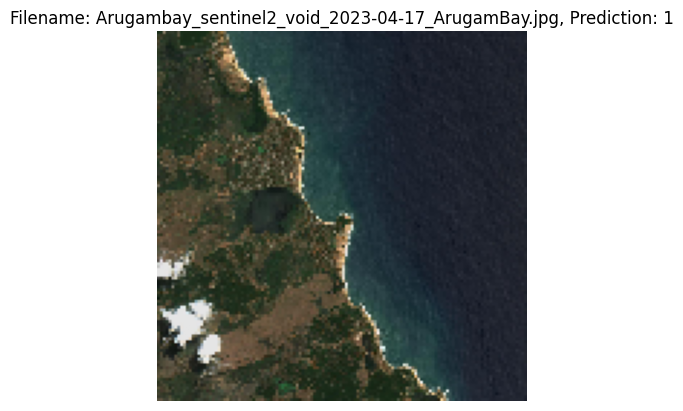

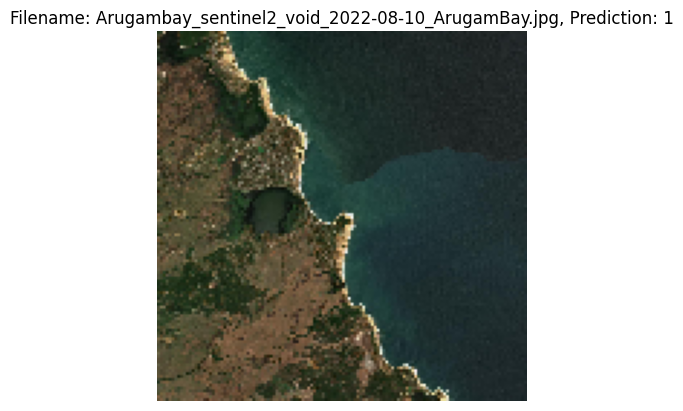

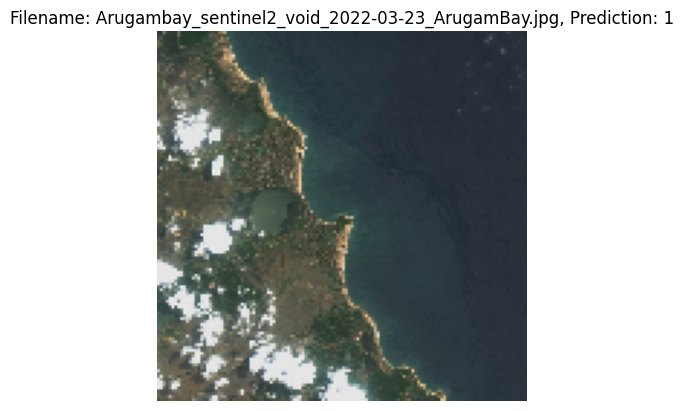

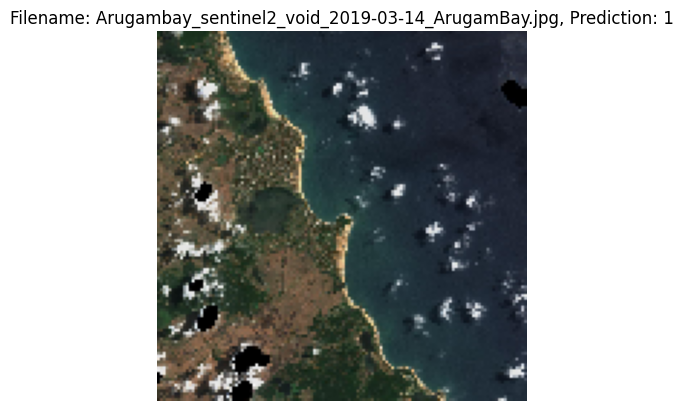

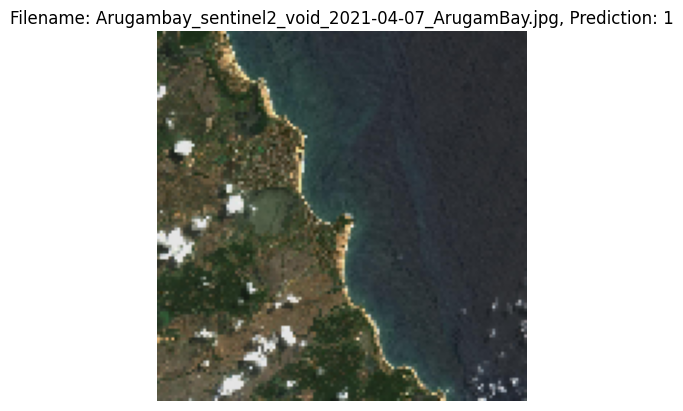

In [ ]:
# Visualize sample predictions.
n_samples_to_display = 5
for i in range(min(n_samples_to_display, len(images))):
    plt.figure()
    plt.imshow(images[i])
    plt.title(f"Filename: {filenames[i]}, Prediction: {predictions[i]}")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Test image prediction: 1 (1 means similar to shoreline, -1 means anomaly)


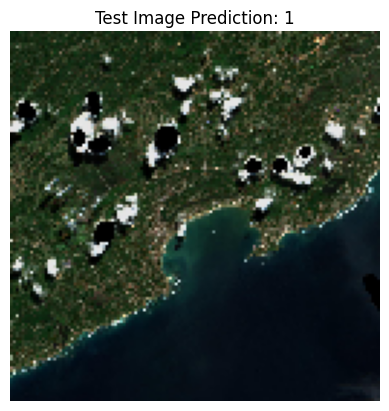

In [ ]:
# Update with the path to your test image.
test_image_path = '/content/drive/MyDrive/DSGP/Datasets/Weligama/Satellite/sentinel2_void_2019-04-23_Weligama.jpg'  # Replace with your test image path

try:
    test_img = load_img(test_image_path, target_size=(128, 128))
    test_img_array = img_to_array(test_img) / 255.0  # Normalize the test image
    test_img_array = np.expand_dims(test_img_array, axis=0)

    # Extract latent features from the test image.
    test_encoded = encoder.predict(test_img_array)
    test_flattened = test_encoded.reshape(1, -1)

    # Predict with the One-Class SVM.
    test_prediction = ocsvm.predict(test_flattened)
    print(f"Test image prediction: {test_prediction[0]} (1 means similar to shoreline, -1 means anomaly)")

    # Display the test image with its prediction.
    plt.figure()
    plt.imshow(test_img_array[0])
    plt.title(f"Test Image Prediction: {test_prediction[0]}")
    plt.axis('off')
    plt.show()
except Exception as e:
    print("Error loading or predicting test image:", e)


In [ ]:
import pickle

# Save the autoencoder model
autoencoder.save("autoencoder.h5")
print("Autoencoder saved as autoencoder.h5")

# Save the encoder model
encoder.save("encoder.h5")
print("Encoder saved as encoder.h5")

# Save the One-Class SVM model using pickle
with open("ocsvm_model.pkl", "wb") as f:
    pickle.dump(ocsvm, f)
print("One-Class SVM saved as ocsvm_model.pkl")


Autoencoder saved as autoencoder.h5
Encoder saved as encoder.h5
One-Class SVM saved as ocsvm_model.pkl
